In [60]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

In [61]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [62]:
### PLOTTING 10 SAMPLES FROM EACH CLASS ###
""" # Create a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(6, 6))

# Iterate over each class
for i, c in enumerate(np.unique(y_train)):
    # Select 10 random samples from this class
    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)
    
    # Iterate over the 10 random samples
    for j, idx_j in enumerate(idx):
        # Get the corresponding image
        img = x_train[idx_j]
        
        # Display the image in the subplot
        axs[j, i].imshow(img)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()
plt.show() """

' # Create a 10x10 subplot grid\nfig, axs = plt.subplots(10, 10, figsize=(6, 6))\n\n# Iterate over each class\nfor i, c in enumerate(np.unique(y_train)):\n    # Select 10 random samples from this class\n    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)\n    \n    # Iterate over the 10 random samples\n    for j, idx_j in enumerate(idx):\n        # Get the corresponding image\n        img = x_train[idx_j]\n        \n        # Display the image in the subplot\n        axs[j, i].imshow(img)\n        axs[j, i].set_xticks([])\n        axs[j, i].set_yticks([])\n\n# Layout so plots do not overlap\nfig.tight_layout()\nplt.show() '

In [63]:
# Normalizing the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [64]:
# Convert the labels from numerical to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [65]:
clear_session()

In [66]:
### MOBILENET MODEL ###
# Load MobileNetV2 with pre-trained weights (for transfer learning) and no top layers
base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights=None)

# Add custom layers on top
model_mobile = Sequential()
model_mobile.add(base_model)                         # Add the MobileNetV2 base model
#model_mobile.add(Dropout(0.2))                       # Drop 20% of the neurons before the Convolutional
model_mobile.add(GlobalAveragePooling2D())           # Global Average Pooling
#model_mobile.add(Dropout(0.5))                       # Drop 50% of the neurons before the Dense layer
model_mobile.add(Dense(10, activation='softmax'))    # Output layer for 10 classes

# Freeze the base_model layers
base_model.trainable = True # Default false

# Define Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', restore_best_weights=True)

do_train_mobile = False

if do_train_mobile:
    # Compiling the model
    model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model_mobile.fit(x_train, y_train,
        epochs=50,
        batch_size=512,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping])

In [67]:
### SEQUENTIAL MODEL ###
# Defining the model
model_seq = Sequential()
model_seq.add(Input(shape=(32, 32, 3)))

model_seq.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model_seq.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model_seq.add(MaxPooling2D((2, 2)))
#model_seq.add(Dropout(0.2))

model_seq.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model_seq.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model_seq.add(MaxPooling2D((2, 2)))
#model_seq.add(Dropout(0.2))

model_seq.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model_seq.add(MaxPooling2D((2, 2)))

model_seq.add(Flatten())
#model_seq.add(Dropout(0.5))

model_seq.add(Dense(100, activation="relu", kernel_initializer="he_uniform"))
#model_seq.add(Dropout(0.5))

model_seq.add(Dense(10, activation="softmax"))

print(model_seq.summary())

# Define Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

do_train_seq = True
if do_train_seq:
    # Compiling the model
    model_seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model_seq.fit(x_train, y_train,
        epochs=100, #50
        batch_size=256, #512
        validation_data=(x_test, y_test),
        validation_split=0.2,
        callbacks=[early_stopping]
        )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

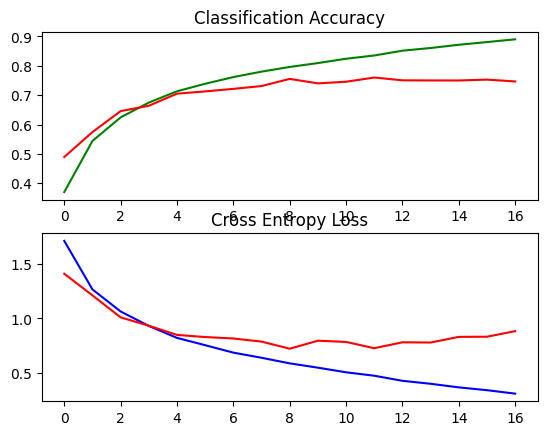

313/313 [==============================] - 1s 2ms/step - loss: 0.7273 - accuracy: 0.7600
Test accuracy: 0.76
Test loss: 0.7273


In [68]:
# Plot Accuracy
plt.subplot(211)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')

# Plot Loss
plt.subplot(212)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')
plt.show()

# Printing the loss and accuracy
model = model_seq

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc.__round__(4))
print('Test loss:', test_loss.__round__(4))

# Adam, DropOuts: Acc = 0.8317 Loss = 0.5056
# Adam, NoDropOuts: Acc = 0.7353 Loss = 0.7353
# SGD, NoDropOuts: Acc = 0.5973 Loss = 1.1429

313/313 [==============================] - 0s 1ms/step


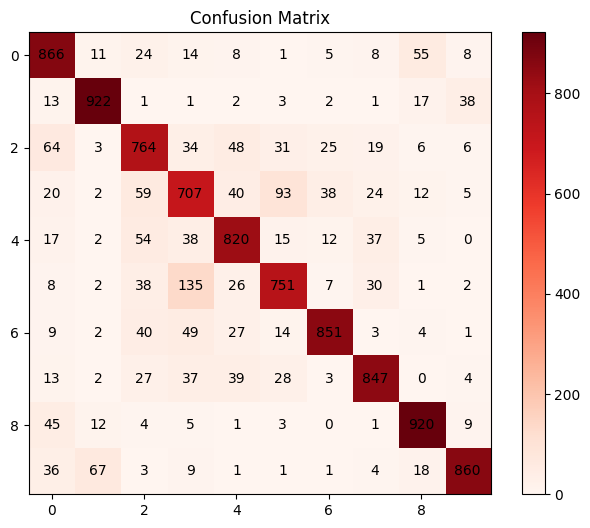

In [19]:
# Making predictions
predictions = model.predict(x_test)

# Creating a Confussion matrix
cm = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(predictions, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion Matrix')
plt.colorbar()

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()